In [1]:
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override() 
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.linear_model import LinearRegression
%matplotlib inline

### 1. Data Description

I choose 2 stocks, PepsiCo(PEP) and Coca-Cola Company(KO) as the pair of stocks. The economic reasons for tight price relationship is they are both beverage companies and their products are almost the same. So their stock price should behave similiar to each other.

In [3]:
stk_1 = pdr.get_data_yahoo("PEP", start="2012-01-01", end="2019-11-30")
stk_2 = pdr.get_data_yahoo("KO", start="2012-01-01", end="2019-11-30")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
stk_close = pd.DataFrame(index=stk_1.index)
stk_close["pep"] = stk_1["Adj Close"]
stk_close["ko"] = stk_2["Adj Close"]
stk_close.head()

,pep,ko
Date,,
2012-01-03,52.519131,26.966385
2012-01-04,52.788052,26.797222
2012-01-05,52.376770,26.670347
2012-01-06,51.720264,26.501183
2012-01-09,51.989201,26.501183


From 2012-2019, the corelation coefficient of these 2 stocks is 0.97, which is very high. I plot the price of these 2 stocks to show their relationship.

In [5]:
print("The corelation between pepsi and coca-cola:",np.corrcoef(stk_close["pep"],stk_close["ko"])[0][1])

The corelation between pepsi and coca-cola: 0.9704735997451671


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
C:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


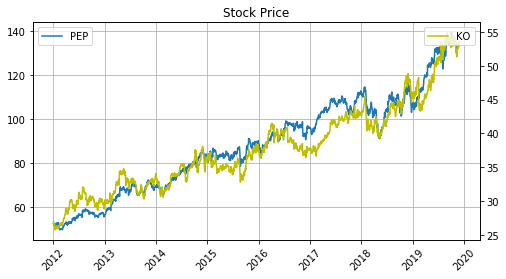

In [6]:
fig = plt.figure(figsize=(8,4))
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Stock Price")
ax1 = fig.add_subplot(1,1,1)
ax1.plot(stk_close.index,stk_close["pep"],label="PEP")
plt.legend()
ax2 = ax1.twinx()
ax2.plot(stk_close.index,stk_close["ko"],"y",label="KO")
plt.legend(loc='upper right')

The following cell proves that the time series of these 2 stocks are I(1) process.

In [7]:
bac_diff = np.diff(stk_close["pep"])
jpm_diff = np.diff(stk_close["ko"])

print("p_value, unit root test for first order difference of PEP:",adfuller(bac_diff)[1])
print("p_value, unit root test for first order difference of KO:",adfuller(jpm_diff)[1])


p_value, unit root test for first order difference of PEP: 0.0
p_value, unit root test for first order difference of KO: 0.0


The following cell proves that these 2 price series are cointergrated.

In [8]:
coint_test = coint(stk_close["pep"],stk_close["ko"])
print("p_value, cointergration test:", round(coint_test[1],3))

p_value, cointergration test: 0.02


### 2. Pairs Trading Strategy

I create the pairs trading function, it takes 4 parameters. L, W ,entry and exit.

    L：the length of the time window used for training.
    W：the length of the window used for trading
    entry: the percentile of z(t), if reached, we will start the trade
    exit: the percentile of z(t), if reached, we will close the trade

Since linear regression makes sure that the residuals got zero mean, so I choose to have symmetric entry and exit point for both directions.

For example, if we set parameters(250,20,10,5), this means we train a model using past 250 days' data and use the model to trade for 20 days. We regress the price of coca-cola against pepsi for our model. Then we get the entry point and exit point for the next 20-days' period.

We have 2 entry points(lower_bound and upper_bound) and 2 exit points(lower_close and upper_close).
    
    lower_bound = the entry(10) percentile of z(t)
    upper_bound = the 1-entry(90) percentile of z(t)
    lower_close = the 50-exit(45) percentile of z(t)
    upper_close = the 50+exit(55) percentile of z(t)
    
If during trading period, the difference of real price and predicted price is larger than upper_bound (coca-cola is over estimated by market), we sell coca-cola and buy pepsi. The amount to sell & buy is calculated in order to make it a self-financing portfolio. We then hold the portfolio until their price difference reached upper_close to take the profit. When the difference of real price and predicted price is smaller than lower_bound, we just do the opposite.

I plot the residuals with entry&exit point, as well as the cumulative returns to see the performance of the strategy.Because it is a self-financing strategy, I start with 0 initial capital.

In [2]:
def pairs_trading(L,W,entry,exit,plot=True):

    log = pd.DataFrame()
    parameters = pd.DataFrame(columns=["lb","lc","uc","cb"])
    status = 0
    for i in range(0,len(stk_close)-L-W,W):
        df = pd.DataFrame(data={"pep":stk_close["pep"][L+i+1:L+i+W],"ko":stk_close["ko"][L+i+1:L+i+W]})
        stk_1_tmp = stk_close["pep"][i:L+i]
        stk_2_tmp = stk_close["ko"][i:L+i]


        model = LinearRegression().fit(np.array(stk_1_tmp).reshape(-1,1), stk_2_tmp)
        r_t = stk_2_tmp- model.predict(np.array(stk_1_tmp).reshape(-1,1)) # residual
        s_t = np.std(r_t) 
        z_t = r_t/s_t

        lower_bound = np.percentile(z_t,entry)
        lower_close = np.percentile(z_t,50-exit)
        upper_close = np.percentile(z_t,50+exit)
        upper_bound = np.percentile(z_t,100-entry)
        parameters.loc[df.index[0]] = [lower_bound,lower_close,upper_close,upper_bound]
        df["ko_predict"] = model.predict(np.array(df["pep"]).reshape(-1,1))
        df["residual"] = (df["ko"]-df["ko_predict"])/s_t
        df["position_pep"] = 0
        df["position_ko"] = 0
  
        action = [0]
      
        for cnt,i in enumerate(df["residual"]):


            if status == 0:
                coef = df.loc[df.index[cnt],"ko"]/df.loc[df.index[cnt],"pep"]
                if i < lower_bound:

                    action.append(1)  # sell pep buy ko
                    status = -1
                    df.loc[df.index[cnt],"position_pep"]= -coef
                    df.loc[df.index[cnt],"position_ko"]= 1

                elif i > upper_bound :

                    action.append(1) # sell ko buy pep
                    status = 1
                    df.loc[df.index[cnt],"position_ko"] = -1
                    df.loc[df.index[cnt],"position_pep"] = coef

                else:
                    action.append(0)

            else:
                if i < lower_bound and status == -1:
                    action.append(0) # keep shorting jpm
                    if cnt == 0 and len(log)>0:
                        df.loc[df.index[cnt],"position_pep"] = log["position_pep"].iloc[-1]
                        df.loc[df.index[cnt],"position_ko"]= 1
                    else:
                        df.loc[df.index[cnt],"position_pep"] = df.loc[df.index[cnt-1],"position_pep"]
                        df.loc[df.index[cnt],"position_ko"]= 1
                elif i > upper_bound and status == 1:
                    action.append(0)
                    if cnt == 0 and len(log)>0:
                        df.loc[df.index[cnt],"position_pep"] = log["position_pep"].iloc[-1]
                        df.loc[df.index[cnt],"position_ko"]= -1
                    else:
                        df.loc[df.index[cnt],"position_ko"] = -1
                        df.loc[df.index[cnt],"position_pep"] = df.loc[df.index[cnt-1],"position_pep"]
                elif i > lower_close and status == -1:
                    action.append(-1)  # close position
                    status = 0
                    if cnt == 0 and len(log)>0:
                        df.loc[df.index[cnt],"position_pep"] = log["position_pep"].iloc[-1]
                        df.loc[df.index[cnt],"position_ko"]= 1
                    else:
                        df.loc[df.index[cnt],"position_pep"] = df.loc[df.index[cnt-1],"position_pep"]
                        df.loc[df.index[cnt],"position_ko"]= 1
                elif i < upper_close and status == 1:
                    action.append(-1) # close position
                    status = 0
                    if cnt == 0 and len(log)>0:
                        df.loc[df.index[cnt],"position_pep"] = log["position_pep"].iloc[-1]
                        df.loc[df.index[cnt],"position_ko"]= -1
                    else:
                        df.loc[df.index[cnt],"position_ko"] = -1
                        df.loc[df.index[cnt],"position_pep"] = df.loc[df.index[cnt-1],"position_pep"]
                else:
                    action.append(0)
                    if cnt == 0 and len(log)>0:
                        df.loc[df.index[cnt],"position_pep"] = log["position_pep"].iloc[-1]
                        df.loc[df.index[cnt],"position_ko"] = log["position_ko"].iloc[-1]
                    else:
                        df.loc[df.index[cnt],"position_ko"] = df.loc[df.index[cnt-1],"position_ko"] 
                        df.loc[df.index[cnt],"position_pep"] = df.loc[df.index[cnt-1],"position_pep"]

        df["action"] = action[1:]
        log = pd.concat([log,df])
        
    log["portfolio_pep"] = log["pep"]*log["position_pep"]
    log["portfolio_ko"] = log["ko"]*log["position_ko"]
    log["portfolio"] = log["portfolio_ko"]+log["portfolio_pep"]
    log["sign"] = ((log["action"]==-1)*log["portfolio"]).cumsum().shift(1)
    log["cumulative return"] = (log["sign"]+log["portfolio"])
    if plot:
        plt.subplots(1,1,figsize=(10,5))
        plt.subplot(1,1,1)
        plt.plot(log.index,log["residual"],parameters)
        log["residual"].plot()
        plt.grid()
        plt.title("Residual")
        plt.legend()
        plt.subplots(1,1,figsize=(10,5))
        plt.subplot(1,1,1)
    
        log["cumulative return"].plot()
        plt.grid()
        plt.title("Cumulative Return")
    
    
    return log


In [3]:
log = pairs_trading(250,20,10,5)

NameError: name 'pd' is not defined

### 3. Performance Analysis

In [1]:
def performance_analysis(log,show=False):
    cret = np.array(log["cumulative return"].dropna())
    draw_down = np.max(np.maximum.accumulate(cret)-cret)
    cum_pnl = cret[-1]/8 # 8 years
    # assume rf = 0.03
    ret = np.diff(cret)
    ret = ret[ret!=0]
    sigma = np.std(ret)/np.sqrt(8)
    sharpe = (cum_pnl-0.03)/sigma
    if show:
        print("max draw_down:",round(draw_down,4))
        print("culmulative pnl:",round(cum_pnl*8,4))
        print("sharpe ratio:",round(sharpe,4))
    return draw_down,cum_pnl*8,sharpe
_ = performance_analysis(log,True)

NameError: name 'log' is not defined

### 4. Sensitivity Test

Firstly, I tested the sensitivity of sharpe ratio with L and W, I found that the performance sharpe ratio is more related to the choice of L. When L is around 450 days , the strategy reaches best sharpe ratio. The PnL is highest when L is around 450 days,too. There seems no linear relation between W and sharpe ratio & PnL.The draw down when L is around 450 days is also the lowest. 40,80 and 120 are all good choices for W.

Then, I test the sensitivity of entry and exit point(as the percentile of zt), from the point we can see that if we set higher upper bound and smaller lower bound, we can get more return. This is because we can get more during the mean reversion process.  For exit point, the conclusion is that it's not optimal to set the exit point exactly 50 percentile of the residual(0). Setting it to 51 percentile for long position & 49 percentile for short position would be a good idea. But generally, exit point is not much related to Sharpe and PnL. For draw down, setting exit point too large will cause higher draw down. Draw down is not related to entry point.

In [111]:
import tqdm
import itertools
from mpl_toolkits.mplot3d import Axes3D

def sensitivity_test(L,W):
    sharpe = []
    pnl = []
    dd = []
    cords = list(itertools.product(L,W))
    for l,w in tqdm.tqdm_notebook(cords):
            d,c,s = performance_analysis(pairs_trading(l,w,10,5,False))
            sharpe.append(s)
            pnl.append(c)
            dd.append(d)
    x,y = zip(*cords)
    return x,y,sharpe,pnl,dd
    

L = [180,210,250,280,300,350,400,450,500]
W = [20,40,60,80,100,120]
x,y,sharpe,pnl,dd = sensitivity_test(L,W)



Text(0.5, 0.92, 'Sensitivity Test of Entry & Exit Point, DrawDown')

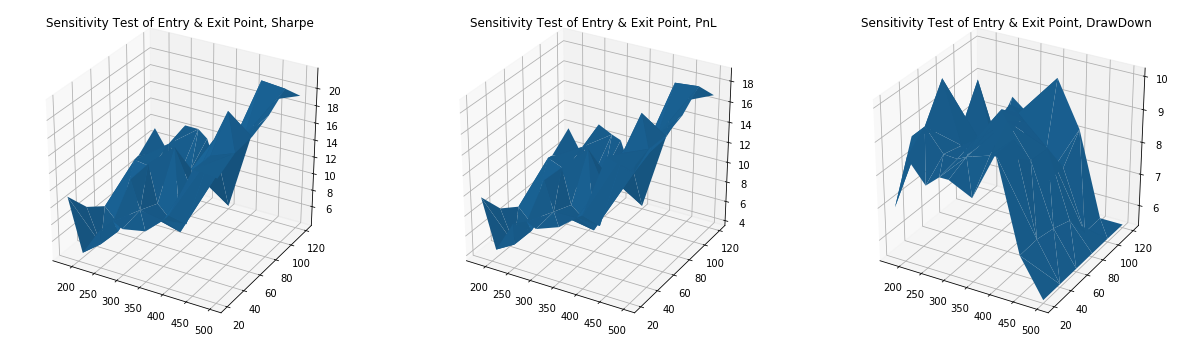

In [112]:
fig = plt.figure(figsize=(21,6))
ax = fig.add_subplot(131, projection='3d')
ax.plot_trisurf(list(x),list(y),sharpe)
plt.title("Sensitivity Test of Entry & Exit Point, Sharpe")
ax = fig.add_subplot(132, projection='3d')
ax.plot_trisurf(list(x),list(y),pnl)
plt.title("Sensitivity Test of Entry & Exit Point, PnL")
ax = fig.add_subplot(133, projection='3d')
ax.plot_trisurf(list(x),list(y),dd)
plt.title("Sensitivity Test of Entry & Exit Point, DrawDown")

In [108]:
def sensitivity_test_2(entry,exit):
    sharpe = []
    pnl = []
    dd = []
    cords = list(itertools.product(entry,exit))
    for en,ex in tqdm.tqdm_notebook(cords):
            d,c,s = performance_analysis(pairs_trading(250,20,en,ex,False))
            sharpe.append(s)
            pnl.append(c)
            dd.append(d)
    x,y = zip(*cords)
    return x,y,sharpe,pnl,dd

entry = [5,6,7,8,9,10,11,12]
exit = [0,1,2,3,4,5,6,7]
x,y,sharpe,pnl,dd = sensitivity_test_2(entry,exit)


Text(0.5, 0.92, 'Sensitivity Test of Entry & Exit Point, DrawDown')

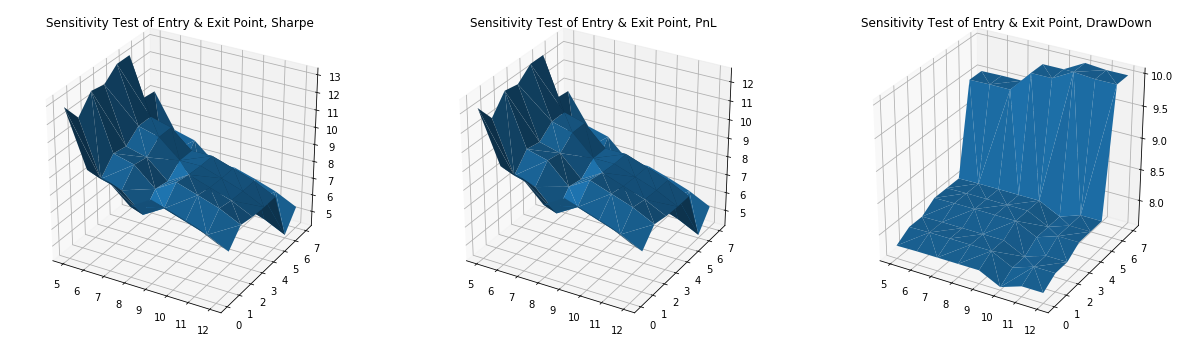

In [109]:
fig = plt.figure(figsize=(21,6))
ax = fig.add_subplot(131, projection='3d')
ax.plot_trisurf(list(x),list(y),sharpe)
plt.title("Sensitivity Test of Entry & Exit Point, Sharpe")
ax = fig.add_subplot(132, projection='3d')
ax.plot_trisurf(list(x),list(y),pnl)
plt.title("Sensitivity Test of Entry & Exit Point, PnL")
ax = fig.add_subplot(133, projection='3d')
ax.plot_trisurf(list(x),list(y),dd)
plt.title("Sensitivity Test of Entry & Exit Point, DrawDown")